In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [124]:
train_df = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [125]:
print(train_df.isnull().sum())
train_df.describe()

id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,18524.000000,17334.000000,17344.000000,17058.000000,17470.000000,17260.000000
mean,9261.500000,3.137764,5.265106,4.044319,7.996737,4.982097
std,5347.562529,3.003786,2.753359,2.062580,4.223484,2.879139
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4630.750000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,9261.500000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,13892.250000,4.000000,8.000000,6.000000,12.000000,7.000000
max,18523.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [126]:
print(test_df.isnull().sum())
test_df.describe()

id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [127]:
print(train_df["Personality"].unique())

['Extrovert' 'Introvert']


In [128]:
def preprocess(df):
    df= df.dropna()
    categorical_cols = ['Stage_fear', 'Drained_after_socializing']
    if "Personality" in df.columns:
        categorical_cols.append('Personality')
    df = pd.get_dummies(df, columns=categorical_cols, dtype=int, dummy_na=True)
    print(df.columns)
    nan_col_names = [col for col in df.columns if "_nan" in col]
    print(f'Dropping {nan_col_names}')
    df = df.drop(nan_col_names, axis=1)
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

Index(['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency', 'Stage_fear_No',
       'Stage_fear_Yes', 'Stage_fear_nan', 'Drained_after_socializing_No',
       'Drained_after_socializing_Yes', 'Drained_after_socializing_nan',
       'Personality_Extrovert', 'Personality_Introvert', 'Personality_nan'],
      dtype='object')
Dropping ['Stage_fear_nan', 'Drained_after_socializing_nan', 'Personality_nan']
Index(['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency', 'Stage_fear_No',
       'Stage_fear_Yes', 'Stage_fear_nan', 'Drained_after_socializing_No',
       'Drained_after_socializing_Yes', 'Drained_after_socializing_nan'],
      dtype='object')
Dropping ['Stage_fear_nan', 'Drained_after_socializing_nan']


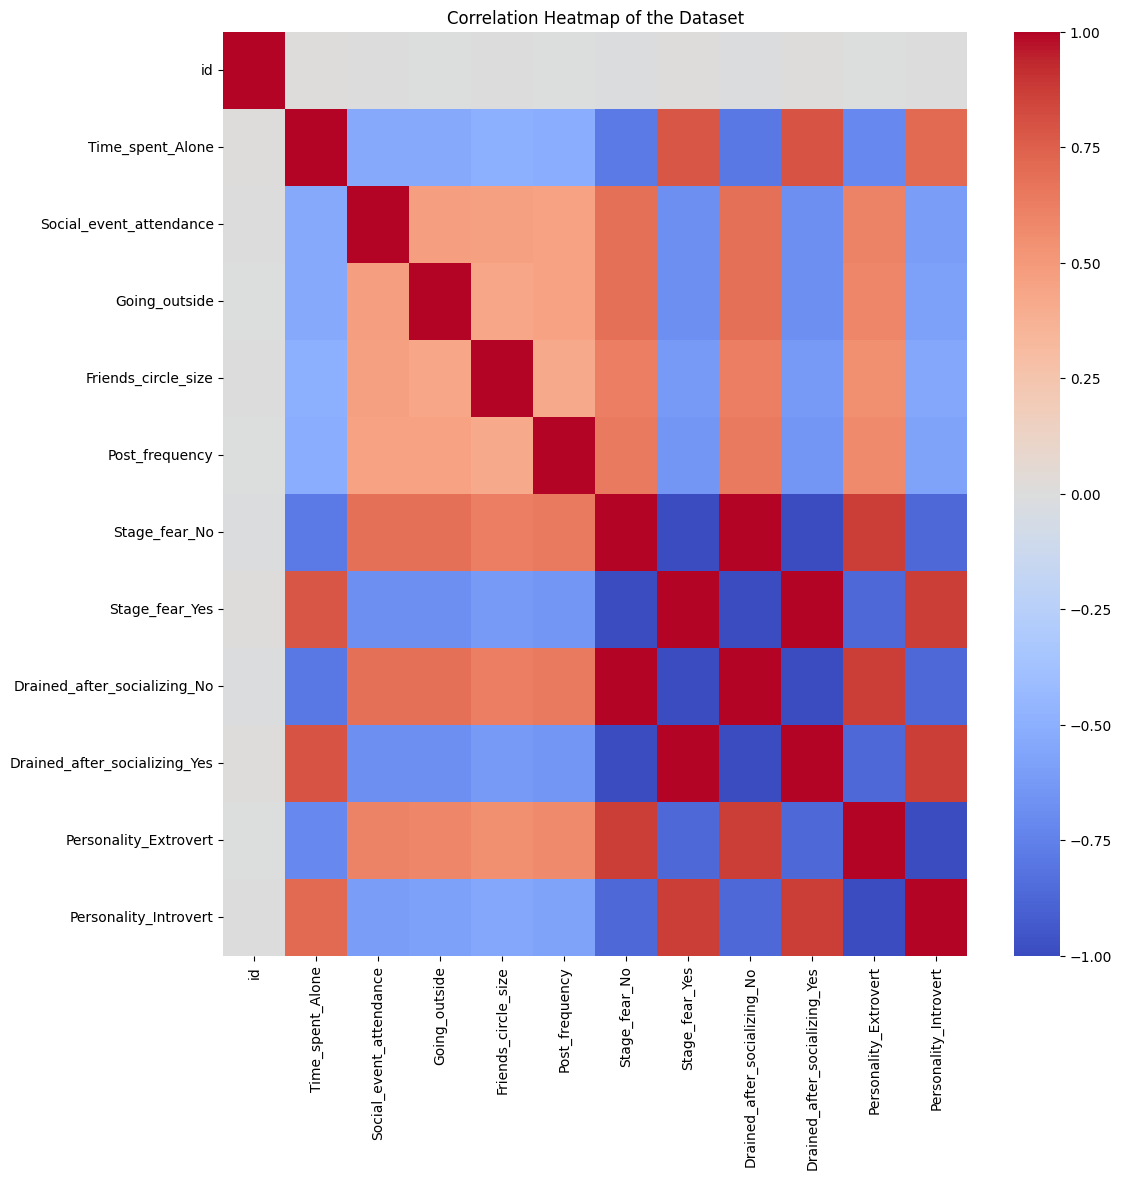

In [129]:
plot_df = train_df.copy()
plt.figure(figsize=(12, 12))
heatmap = sns.heatmap(plot_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of the Dataset")
plt.show()

In [130]:
from sklearn.model_selection import train_test_split

X = train_df.drop(["Personality_Introvert", 'id', 'Personality_Extrovert'], axis=1)
y = train_df["Personality_Introvert"]
print(X.head)
print(y.head)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

<bound method NDFrame.head of        Time_spent_Alone  Social_event_attendance  Going_outside  \
0                   0.0                      6.0            4.0   
1                   1.0                      7.0            3.0   
3                   3.0                      7.0            3.0   
7                   2.0                      8.0            3.0   
9                   1.0                      8.0            6.0   
...                 ...                      ...            ...   
18509               1.0                      3.0            4.0   
18511               0.0                      4.0            5.0   
18514               6.0                      5.0            3.0   
18519               3.0                      7.0            3.0   
18523               1.0                      8.0            6.0   

       Friends_circle_size  Post_frequency  Stage_fear_No  Stage_fear_Yes  \
0                     15.0             5.0              1               0   
1          

In [131]:
print(len(X_train))
print(len(y_train))

8151
8151


In [132]:
from sklearn.metrics import accuracy_score

model_xg = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify the learning task
    n_estimators=50,             # Number of boosting rounds (trees)
    learning_rate=0.16,            # Step size shrinkage
    max_depth=25,                  # Maximum depth of a tree
    use_label_encoder=False,     
    eval_metric='mlogloss'   )

model_xg.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model_xg.predict(X_test)

# 6. Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.96


In [133]:
ids = test_df['id']
y_test = model_xg.predict(test_df.drop("id", axis=1))

In [134]:
submission = pd.DataFrame({'id': ids, 'y': y_test})
submission.loc[submission['y'] == 0, 'y'] = 'Extrovert'
submission.loc[submission['y'] == 1, 'y'] = 'Introvert'
submission.to_csv('submission.csv', index=False)

/tmp/ipykernel_36/2582849635.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Extrovert' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  submission.loc[submission['y'] == 0, 'y'] = 'Extrovert'


In [135]:
submission.head()

,id,y
2,18526,Extrovert
3,18527,Extrovert
4,18528,Introvert
5,18529,Extrovert
6,18530,Extrovert
